## Implementation

In [19]:
import tensorflow as tf
print('Tensorflow version : {}'.format(tf.__version__))
print('GPU : {}'.format(tf.config.list_physical_devices('GPU')))
#tf.config.experimental.list_physical_devices('GPU')
from tensorflow import keras
import tensorflow.keras.backend as K

Tensorflow version : 2.4.1
GPU : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [125]:
# Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, concatenate, Dense, Average, Dropout, LeakyReLU, Reshape, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Lambda, Activation, Flatten, Convolution1D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import np_utils
#from tensorflow.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import Model, Input
from tensorflow.keras.applications.vgg19 import VGG19
#from keras_squeezenet_tf2 import SqueezeNet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

## Tensorboard

In [126]:
import tensorboard
tensorboard.__version__

'2.4.1'

In [127]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [133]:
%tensorboard --logdir=logs --host localhost --port 6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
2021-02-19 06:59:20.041504: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
W0219 06:59:21.478068 139801514247936 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0219 06:59:21.482350 139801514247936 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0219 06:59:21.497611 139801514247936 plugin_event_accumulator.py:322] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0219 06:59:21.504721 139801514247936 plugin_ev

In [134]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 646), started 0:19:09 ago. (Use '!kill 646' to kill it.)

In [39]:
#https://github.com/sivaramakrishnan-rajaraman/Deep-Neural-Ensembles-toward-Malaria-Parasite-Detection-in-Thin-Blood-Smear-Images/blob/master/model_ensemble.ipynb

In [40]:
#splitfolders.ratio('../data/cell_images', output='../data/cell_images/', seed=1337, ratio=(.8, 0.1,0.1)) 

In [41]:
# custom function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False, #if true all values in confusion matrix is between 0 and 1
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [143]:
#%% Loading the data

img_width, img_height = 100, 100
train_data_dir = '../data/cell_images/train'
validation_data_dir = '../data/cell_images/test'
epochs = 2
batch_size = 16 
num_classes= 2

# Since the models work with the data of the same shape, we 
#define a single input layer that will be used by every model.

input_shape = (100,100,3)
model_input = Input(shape=input_shape)
print(model_input) 

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='input_28'), name='input_28', description="created by layer 'input_28'")


In [144]:
#%% declaring image data generators

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=2,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.5,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(100,100),
        batch_size=batch_size,
        class_mode='categorical',shuffle=False)

#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)

#check the class indices
train_generator.class_indices
validation_generator.class_indices

#true labels
Y_test=validation_generator.classes

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [145]:
#%% assign class weights to balance model training and penalize over-represented classes

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)
print(class_weights)

[1. 1.]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


## SqueezeNet 

In [147]:
from keras_squeezenet_tf2 import SqueezeNet

In [148]:
#%% SqueezeNet 

def squeeze_cnn(model_input):
    squeeze_cnn = SqueezeNet(weights='imagenet', include_top=False, input_tensor=model_input)
    x = squeeze_cnn.layers[-3].output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=squeeze_cnn.input, outputs=predictions, name='squeeze_custom')
    return model

#instantiate the model
squeeze_custom_model = squeeze_cnn(model_input)

#display model summary
squeeze_custom_model.summary()

Model: "squeeze_custom"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 49, 49, 64)   1792        input_28[0][0]                   
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 49, 49, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 24, 24, 64)   0           relu_conv1[0][0]                 
_____________________________________________________________________________________

In [149]:
# #%% SqueezeNet 
# # https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/07_Keras_Flowers_TPU_squeezenet.ipynb#scrollTo=XLJNVGwHUDy1



# bnmomemtum=0.9
# def fire(x, squeeze, expand):
#     y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
#     y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
#     y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
#     y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
#     y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
#     y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
#     return tf.keras.layers.concatenate([y1, y3])

# def fire_module(squeeze, expand):
#     return lambda x: fire(x, squeeze, expand)

# def squeeze_cnn(model_input):
#     x = tf.keras.layers.Input(tensor=model_input) # input is 192x192 pixels RGB

#     y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
#     y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
#     y = fire_module(24, 48)(y)
#     y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
#     y = fire_module(48, 96)(y)
#     y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
#     y = fire_module(64, 128)(y)
#     y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
#     y = fire_module(48, 96)(y)
#     y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
#     y = fire_module(24, 48)(y)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     y = tf.keras.layers.Dense(2, activation='softmax')(y)

#     model = Model(x, y, name='squeeze_custom_model')
#     return model

# squeeze_custom_model = squeeze_cnn(model_input)
# # x = tf.keras.layers.Input(shape=input_shape) # input is 192x192 pixels RGB

# # y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
# # y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
# # y = fire_module(24, 48)(y)
# # y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
# # y = fire_module(48, 96)(y)
# # y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
# # y = fire_module(64, 128)(y)
# # y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
# # y = fire_module(48, 96)(y)
# # y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
# # y = fire_module(24, 48)(y)
# # y = tf.keras.layers.GlobalAveragePooling2D()(y)
# # y = tf.keras.layers.Dense(2, activation='softmax')(y)

# # squeeze_custom_model = Model(x, y, name='squeeze_custom_model')

# # squeeze_custom_model.compile(
# # optimizer='adam',
# # loss= 'categorical_crossentropy',
# # metrics=['accuracy'])

# squeeze_custom_model.summary()

In [150]:
#%% compile and train the squeezenet model

adam = Adam(lr=0.0001) 
squeeze_custom_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 

# opt = Adam(learning_rate=0.0001)
# squeeze_custom_model.compile(loss='categorical_crossentropy', 
#                              optimizer=opt,
#                             metrics=[tf.keras.metrics.BinaryAccuracy()])

metric = 'val_accuracy'
checkpoint = ModelCheckpoint(filepath='weights/' + squeeze_custom_model.name + '.h5', 
                             monitor = metric,
                             verbose = 0, 
                             save_weights_only=False,
                             save_best_only=True, 
                             mode='max')
                            #save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, tensor_board, reduce_lr]
history = squeeze_custom_model.fit(train_generator, steps_per_epoch= nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks= callbacks_list, 
                                  validation_steps= nb_validation_samples // batch_size, verbose=1)    

Epoch 1/2
1377/1377 [==============================] - 66s 47ms/step - loss: 0.3096 - accuracy: 0.8712 - val_loss: 0.1566 - val_accuracy: 0.9586
Epoch 2/2
1377/1377 [==============================] - 65s 47ms/step - loss: 0.2048 - accuracy: 0.9278 - val_loss: 0.1255 - val_accuracy: 0.9578


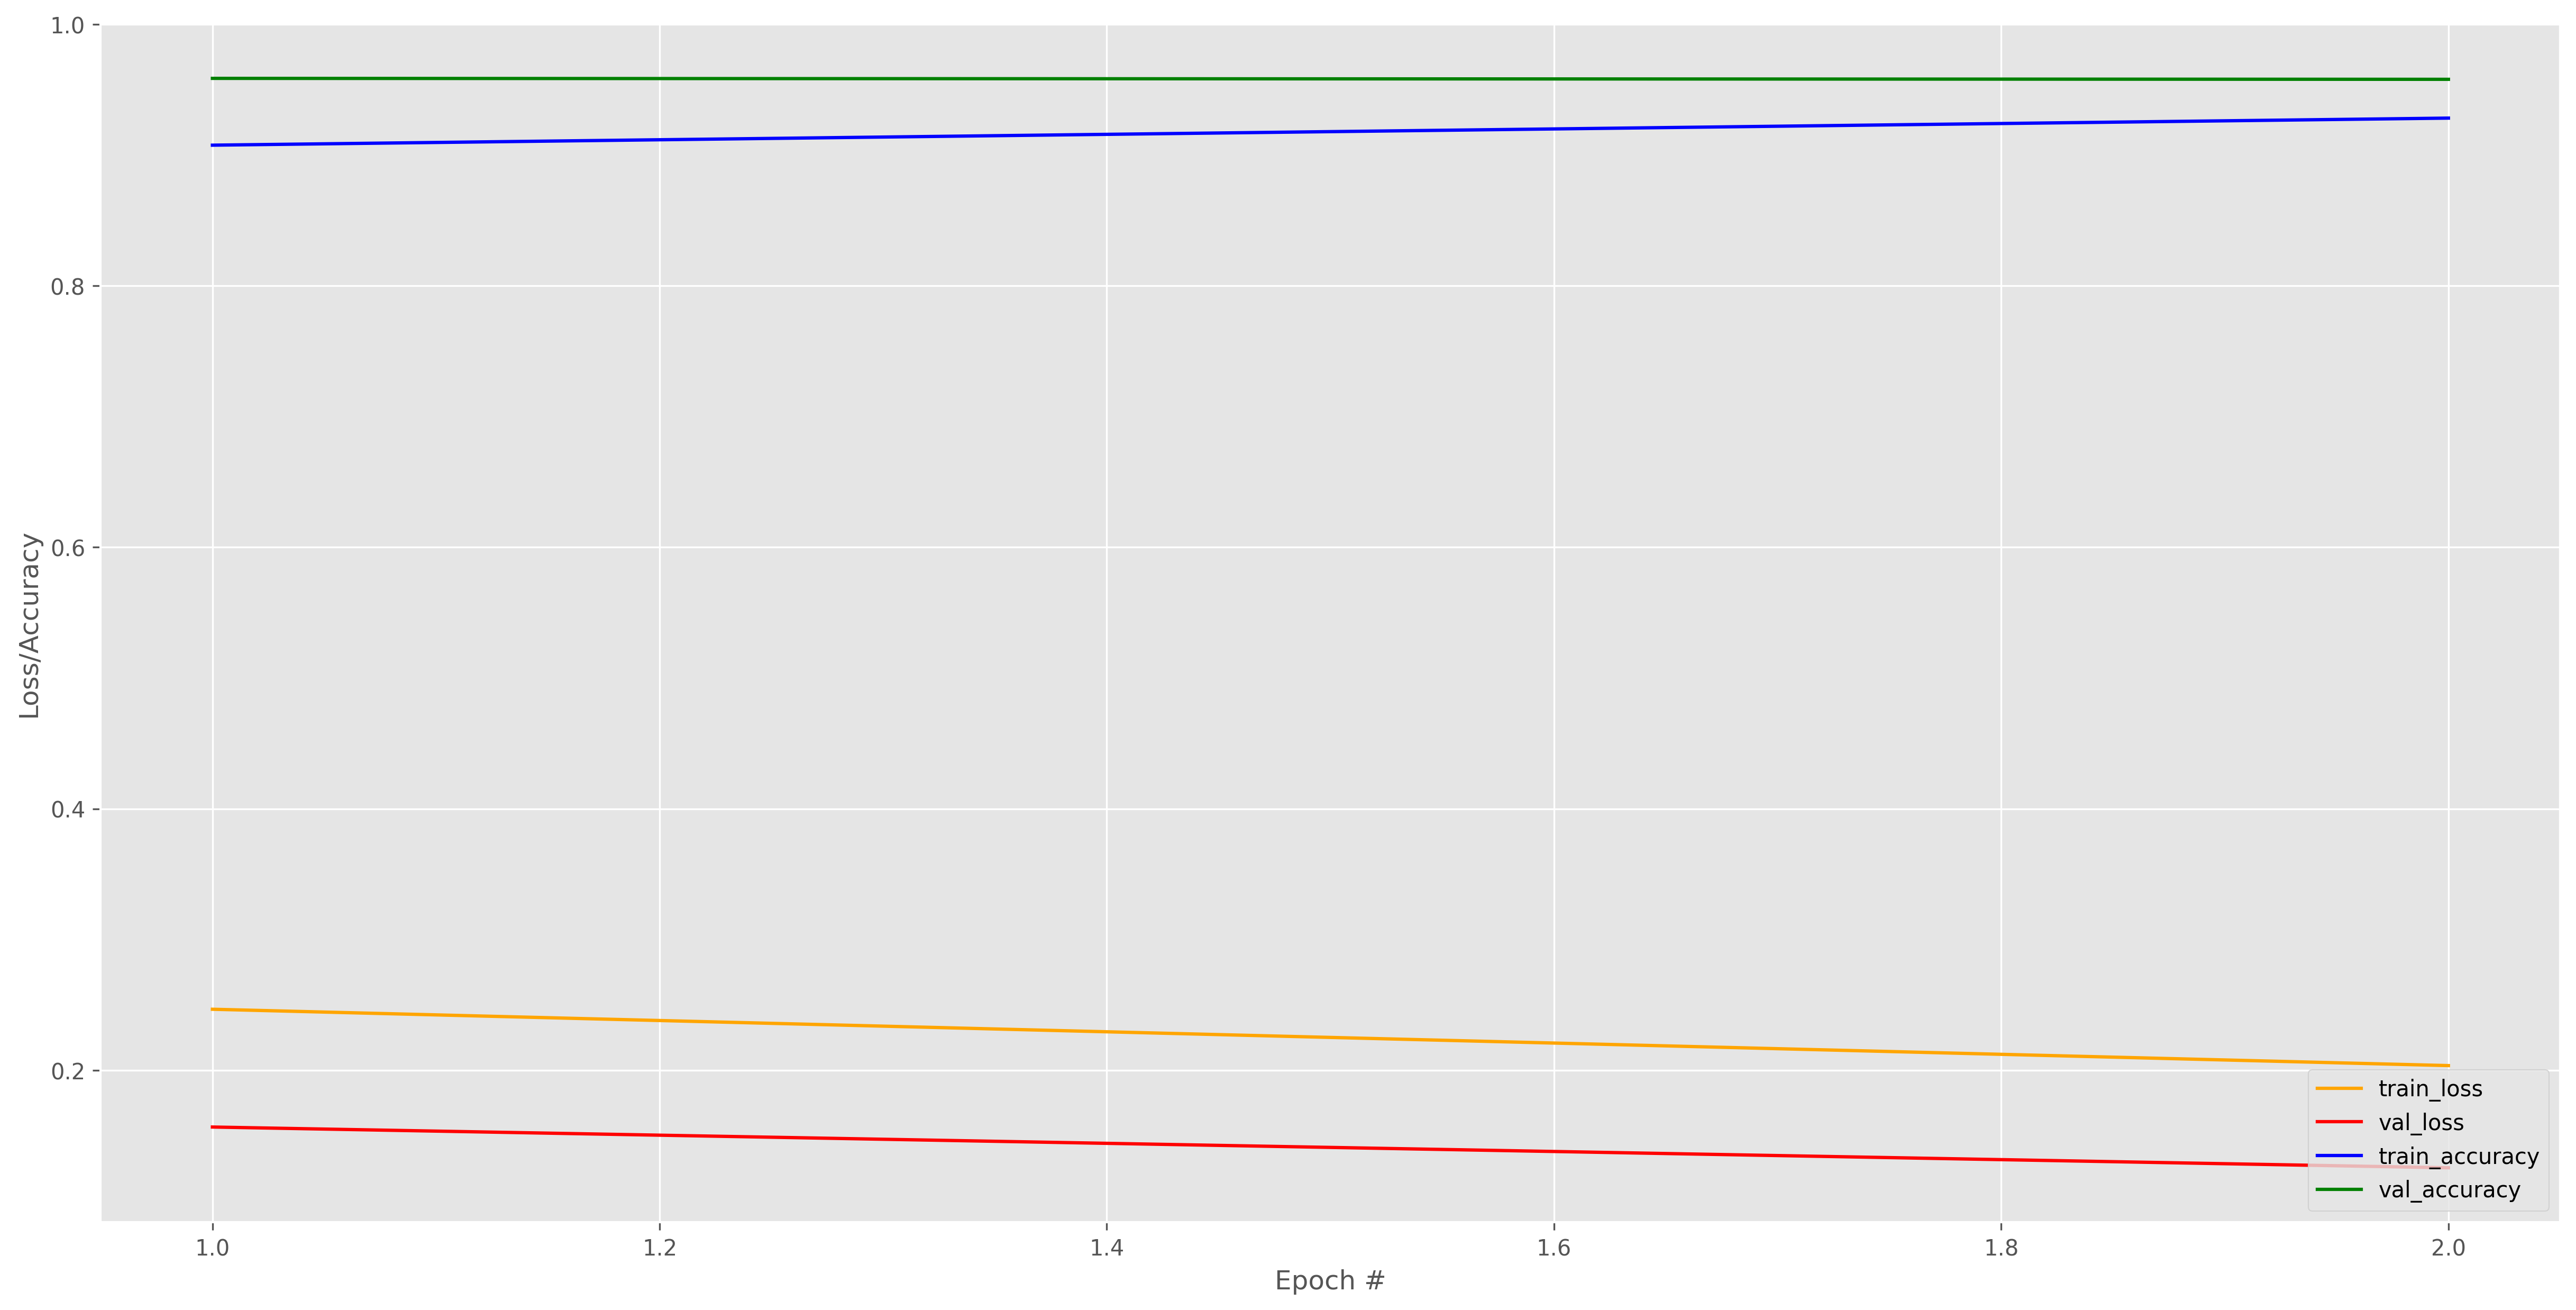

In [151]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_accuracy")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("logs/SqueezeNet_custom_plot.png")

## VGG19

In [26]:
#%% VGG19 model 

def vgg19_cnn(model_input):
    vgg19_cnn = VGG19(weights='imagenet', include_top=False, input_tensor=model_input)
    x = vgg19_cnn.layers[-2].output 
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=vgg19_cnn.input, outputs=predictions, name='vgg19_custom')
    return model

#instantiate the model
vgg19_custom_model = vgg19_cnn(model_input)

#plot model summary
vgg19_custom_model.summary()


Model: "vgg19_custom"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [30]:
#%% compile and train the VGG19 model

adam = Adam(lr=0.0001)
vgg19_custom_model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy']) 
filepath = 'weights/' + vgg19_custom_model.name + '.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, 
                             save_weights_only=False, save_best_only=True, mode='max') #, save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

tensor_board = TensorBoard(log_dir='logs/', histogram_freq=0)
callbacks_list = [checkpoint, tensor_board, reduce_lr]
history = vgg19_custom_model.fit(train_generator, steps_per_epoch=nb_train_samples // batch_size,
                                  epochs=epochs, validation_data=validation_generator,
                                  #class_weight = class_weights,
                                  callbacks=callbacks_list, 
                                  validation_steps=nb_validation_samples // batch_size, verbose=1)

Epoch 1/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.3496 - accuracy: 0.8481 - val_loss: 0.1311 - val_accuracy: 0.9582
Epoch 2/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.2122 - accuracy: 0.9260 - val_loss: 0.1313 - val_accuracy: 0.9582
Epoch 3/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.1990 - accuracy: 0.9330 - val_loss: 0.1460 - val_accuracy: 0.9586
Epoch 4/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.1840 - accuracy: 0.9371 - val_loss: 0.1512 - val_accuracy: 0.9582
Epoch 5/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.1779 - accuracy: 0.9374 - val_loss: 0.1204 - val_accuracy: 0.9597
Epoch 6/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.1717 - accuracy: 0.9395 - val_loss: 0.1084 - val_accuracy: 0.9615
Epoch 7/60
1377/1377 [==============================] - 66s 48ms/step - loss: 0.1762 - accuracy: 0.9366 - val_loss: 0.1132 -

Epoch 55/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.0935 - accuracy: 0.9635 - val_loss: 0.0763 - val_accuracy: 0.9727
Epoch 56/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.0976 - accuracy: 0.9647 - val_loss: 0.0798 - val_accuracy: 0.9731
Epoch 57/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.0912 - accuracy: 0.9669 - val_loss: 0.0813 - val_accuracy: 0.9757
Epoch 58/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.0956 - accuracy: 0.9635 - val_loss: 0.0773 - val_accuracy: 0.9727
Epoch 59/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.0933 - accuracy: 0.9662 - val_loss: 0.0796 - val_accuracy: 0.9738
Epoch 60/60
1377/1377 [==============================] - 65s 47ms/step - loss: 0.0929 - accuracy: 0.9654 - val_loss: 0.0743 - val_accuracy: 0.9746


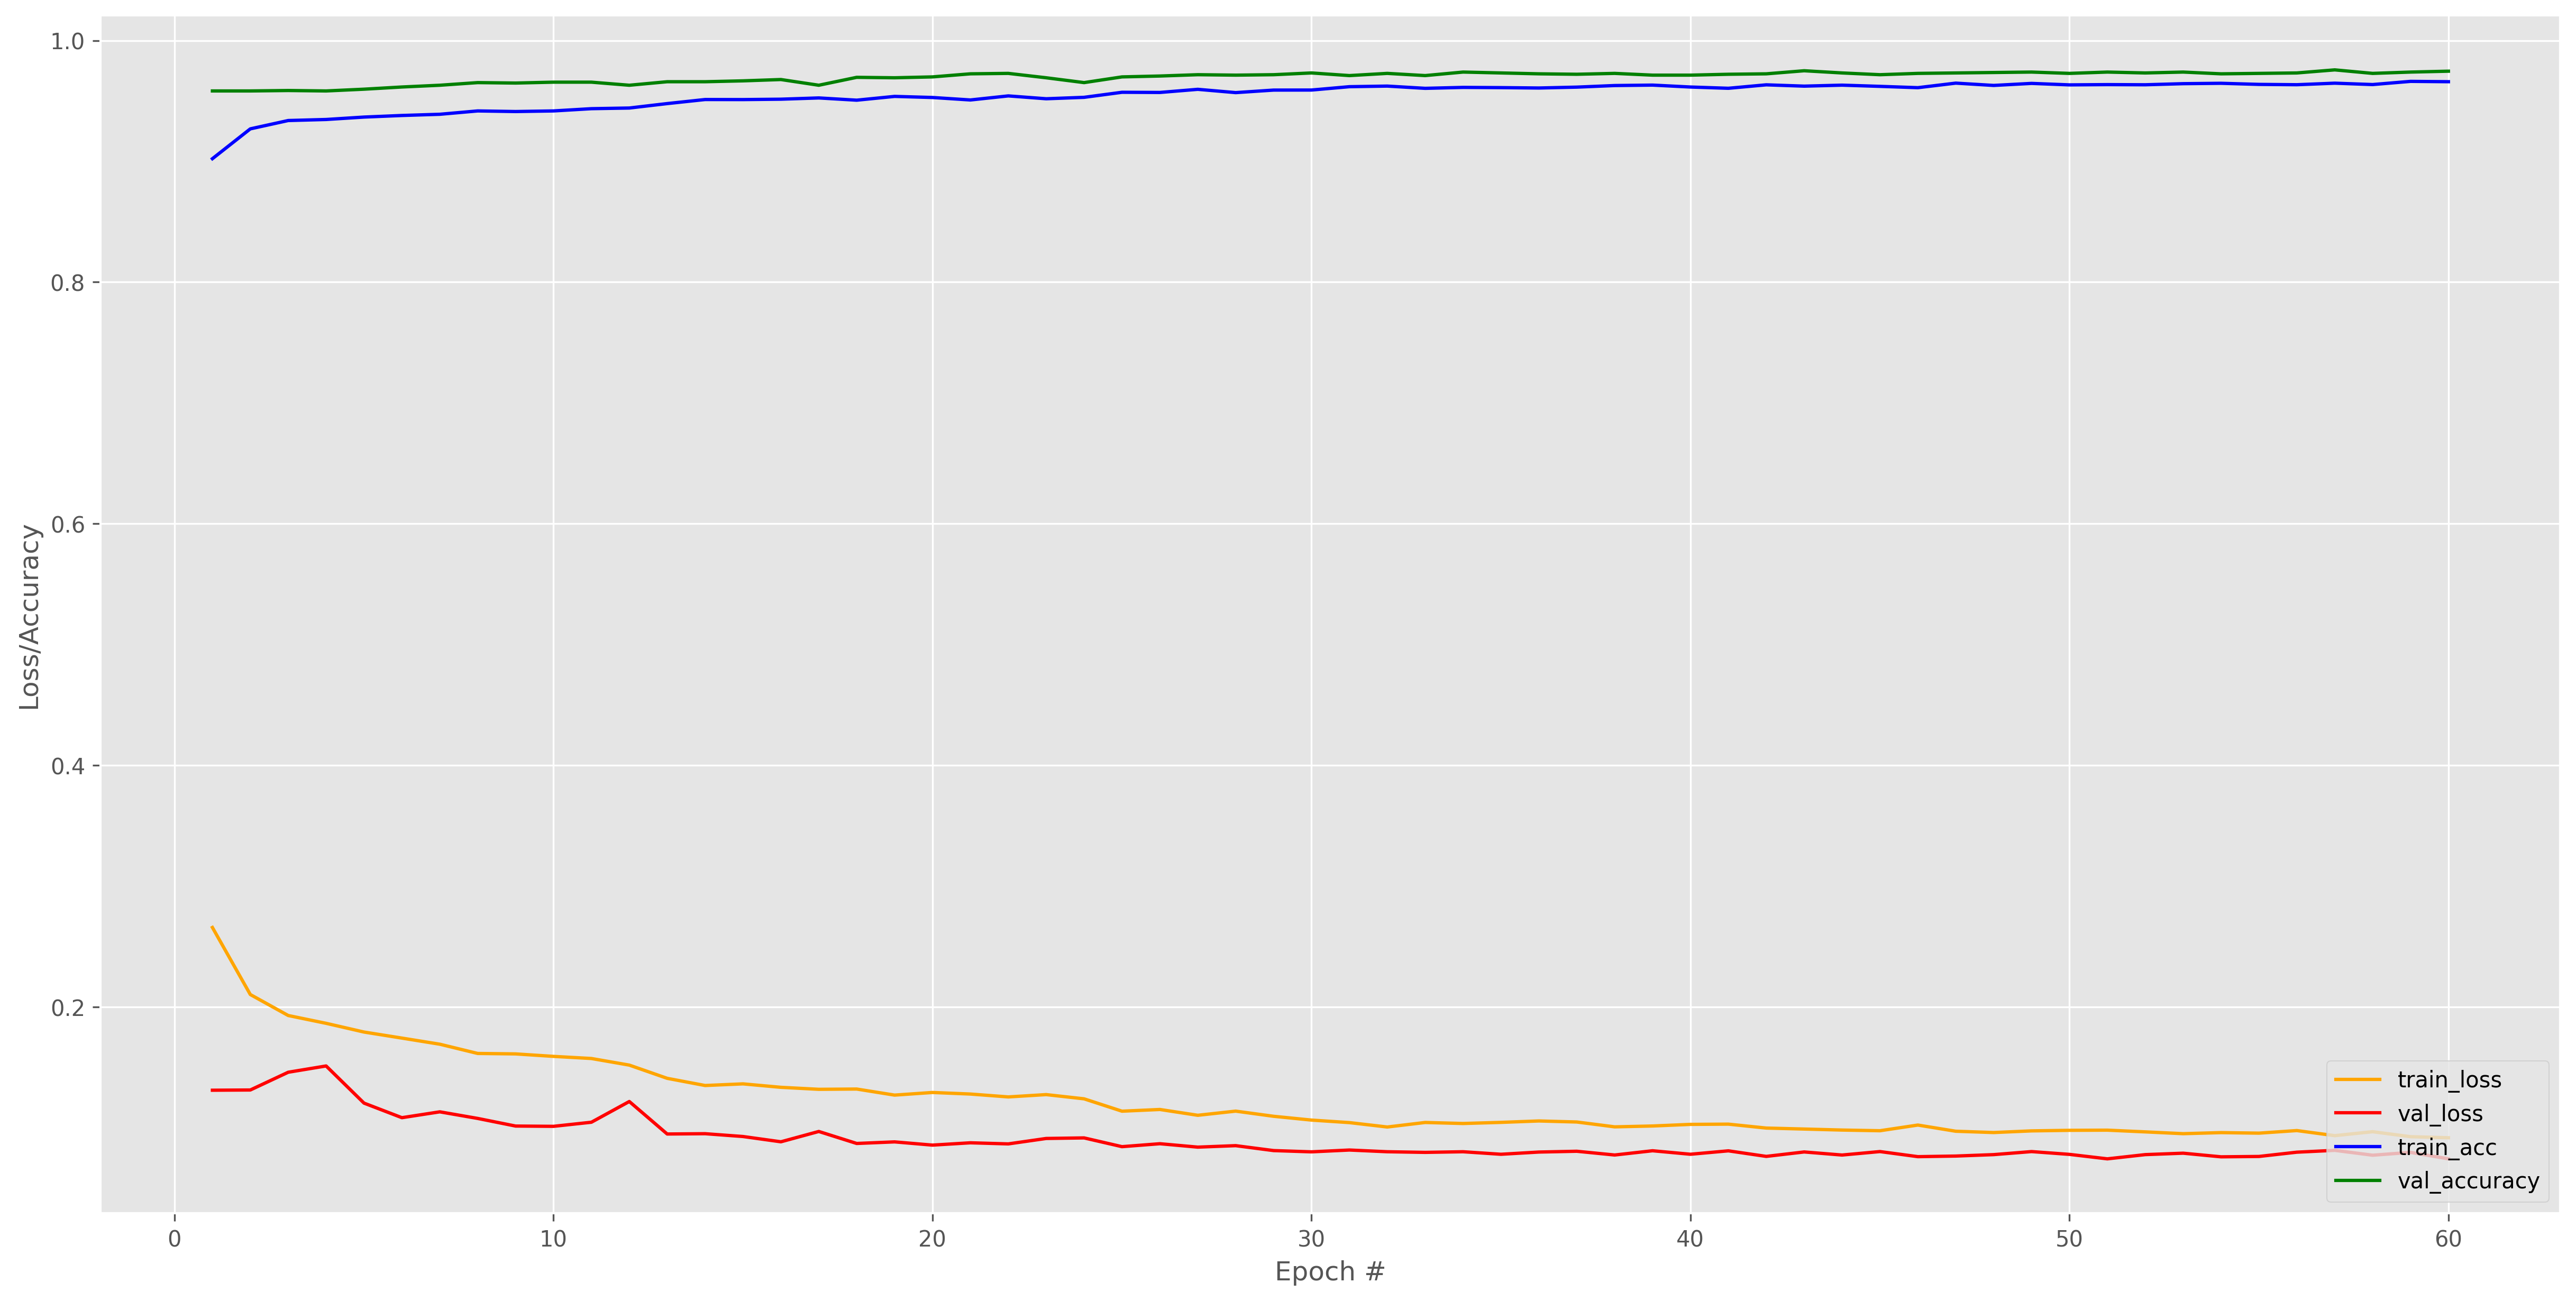

In [31]:
N = epochs
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=300)
plt.plot(np.arange(1, N+1), history.history["loss"], 'orange', label="train_loss")
plt.plot(np.arange(1, N+1), history.history["val_loss"], 'red', label="val_loss")
plt.plot(np.arange(1, N+1), history.history["accuracy"], 'blue', label="train_acc")
plt.plot(np.arange(1, N+1), history.history["val_accuracy"], 'green', label="val_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("VGG19_custom_plot.png")

In [33]:
#Evaluate the model by loading the best weights 
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')

#evaluate accuracy
vgg19_custom_y_pred = vgg19_custom_model.predict(validation_generator,
                                                           nb_validation_samples/batch_size, workers=1)
vgg19_accuracy = accuracy_score(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The accuracy of the VGG19 Custom model is: ', vgg19_accuracy)

#evaluate mean squared error
vgg19_custom_mse = mean_squared_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the VGG19 Custom model is: ', vgg19_custom_mse)

#evaluate mean squared log error
vgg19_custom_msle = mean_squared_log_error(Y_test,vgg19_custom_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the VGG19 Custom model is: ', vgg19_custom_msle)

The accuracy of the VGG19 Custom model is:  0.9756894049346879
The Mean Squared Error of the VGG19 Custom model is:  0.024310595065312045
The Mean Squared Log Error of the VGG19 Custom model is:  0.011680098669274126


                   precision    recall  f1-score   support

class 0(abnormal)     0.9733    0.9782    0.9758      1378
  class 1(normal)     0.9781    0.9731    0.9756      1378

         accuracy                         0.9757      2756
        macro avg     0.9757    0.9757    0.9757      2756
     weighted avg     0.9757    0.9757    0.9757      2756

Confusion matrix, without normalization
[[1348   30]
 [  37 1341]]


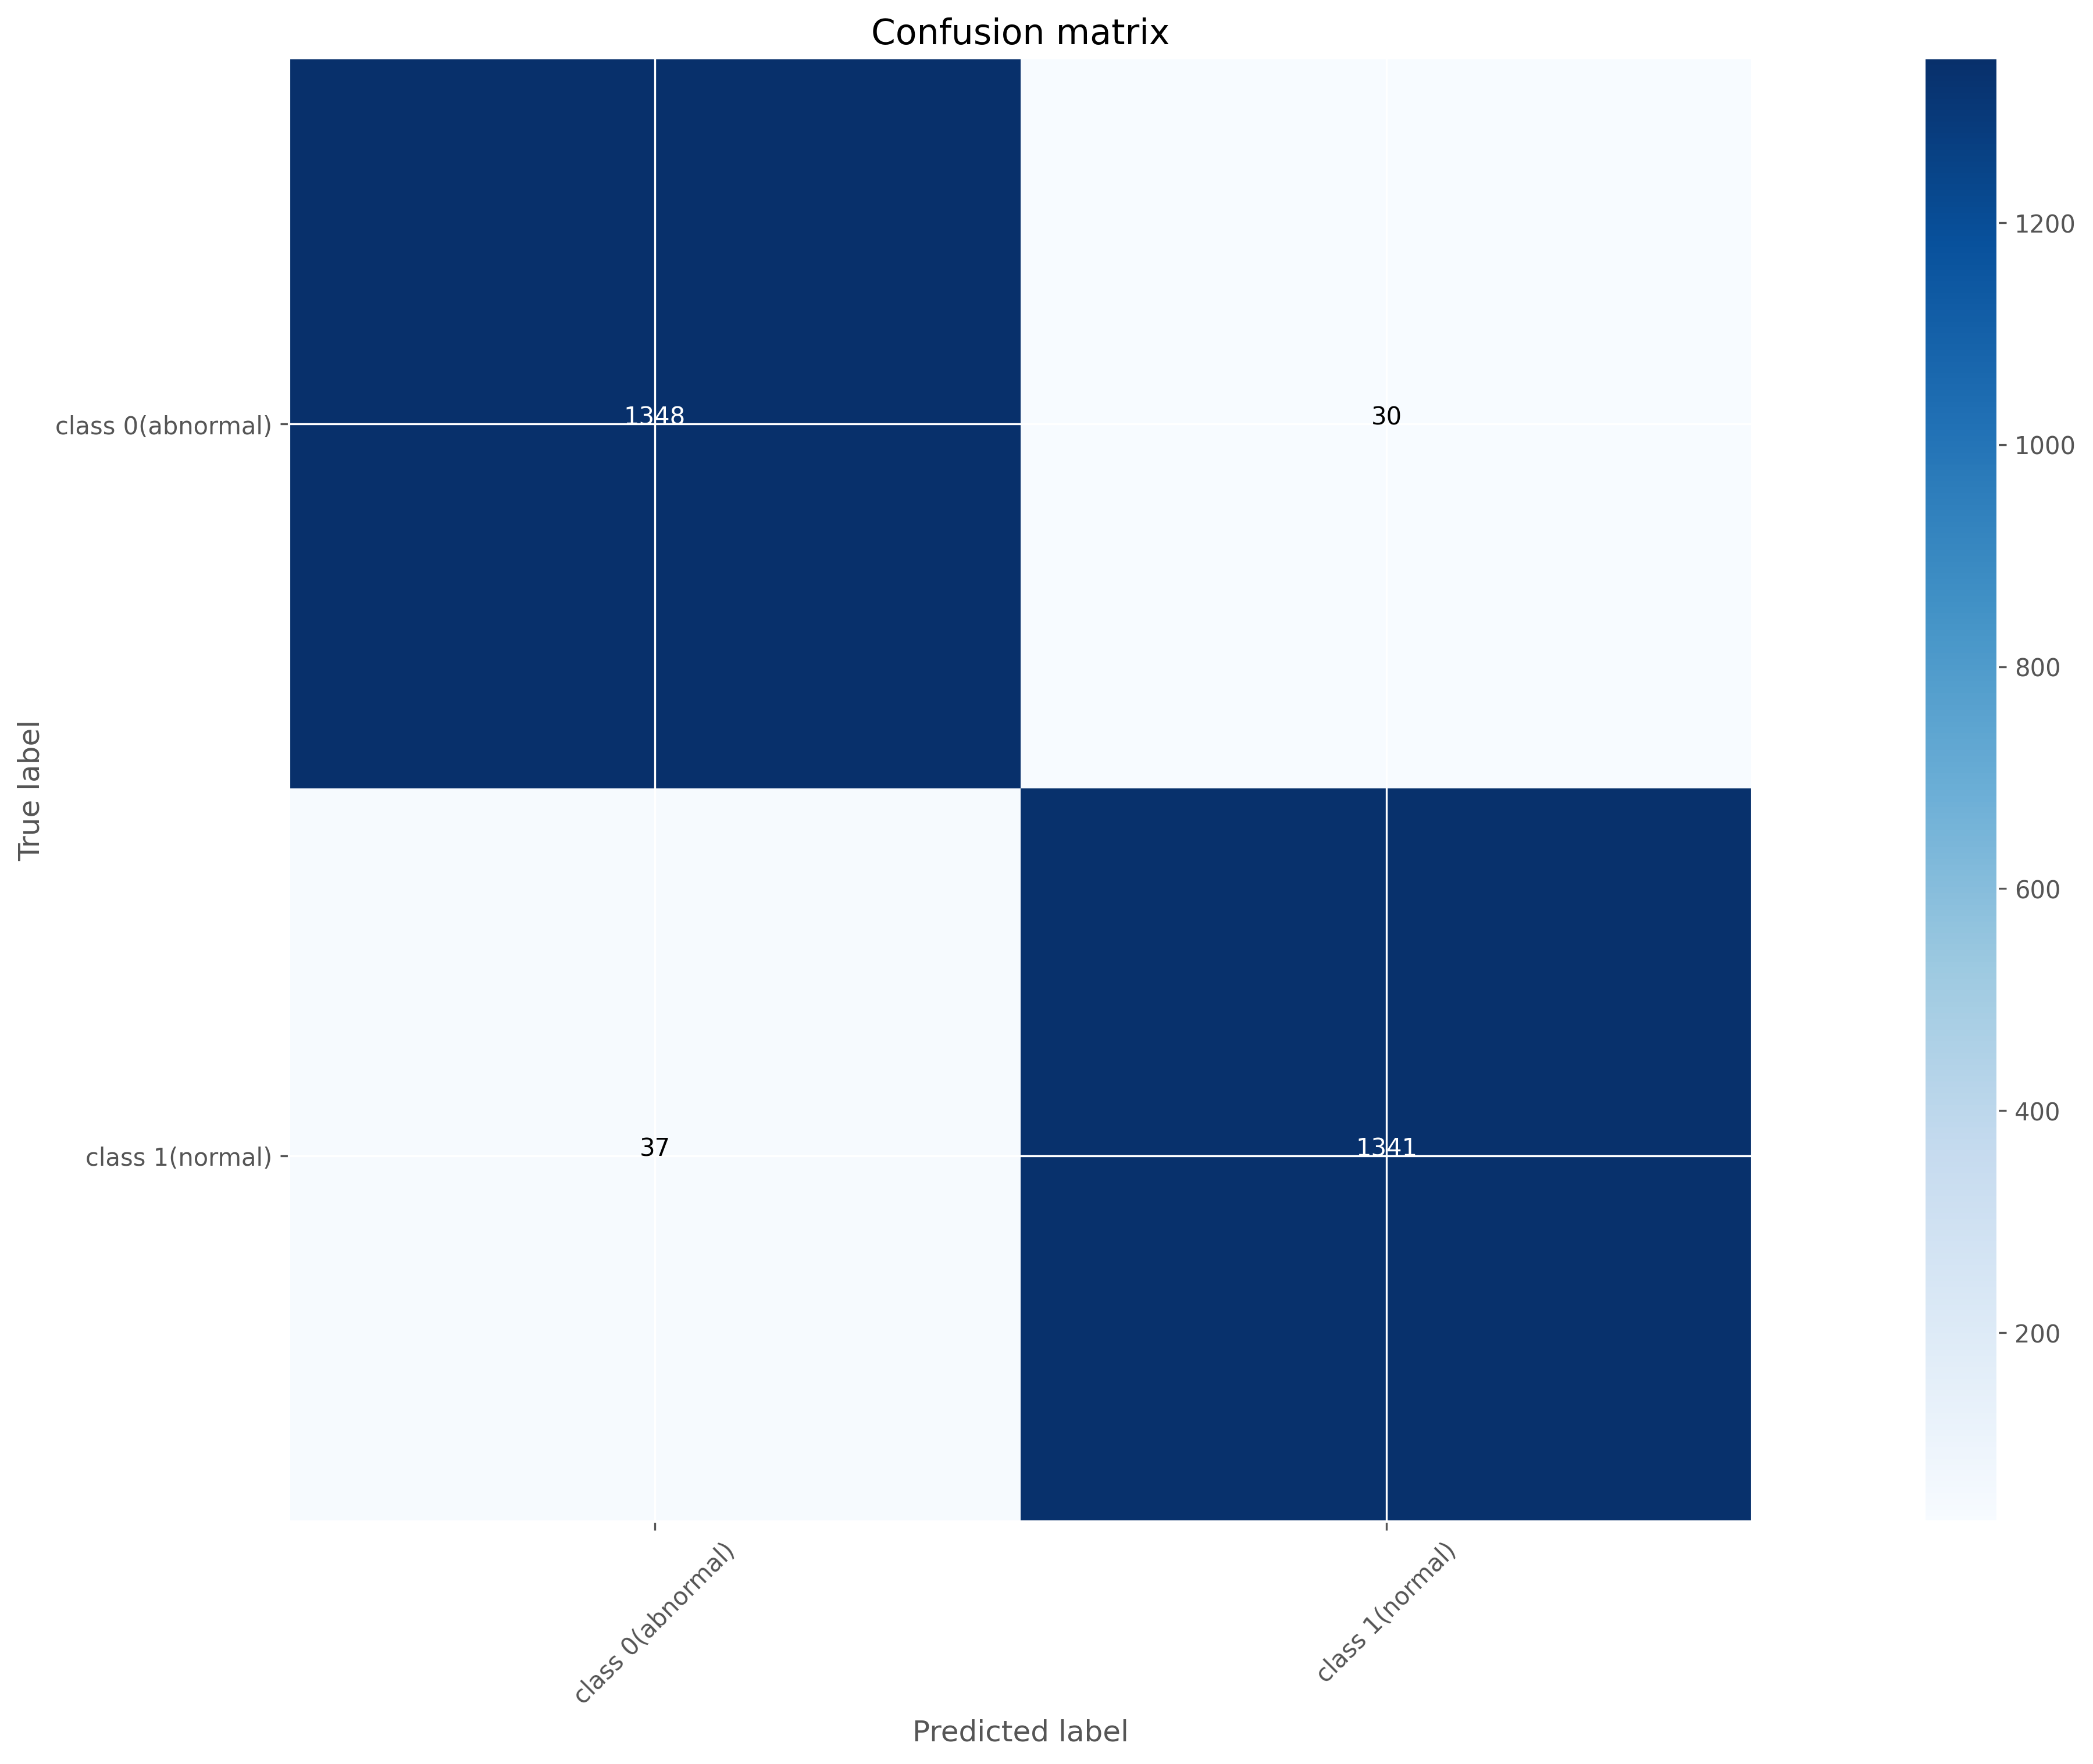

In [44]:
#%% print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,vgg19_custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,vgg19_custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()

## Ensemble SqueezeNet and VGG19

In [176]:
#%% modify squeezenet layer name to avoid common names while forming ensemble

squeeze_custom_model.get_layer(name='conv1').name='conv1SQUEEZE'

AttributeError: Can't set the attribute "name", likely because it conflicts with an existing read-only @property of the object. Please choose a different name.

In [216]:
def ensemble(models, model_input):
    model_1 = models[0]
    model_2 = models[1]
    layers = [layer.output for layer in model_1.layers]
    model_merge = Model(inputs=model_1.input, 
                    outputs=Activation('softmax')(model_2(layers[0])))

    return model_merge

def ensemble(models, model_input):
    
    outputs = [m.output for m in models]
    print(outputs)
    y = Average()(outputs) 
    model = Model(input_tensor = model_input, output = y, name='ensemble')
    return model


In [217]:
#%% construct the ensemble model
vgg19_custom_model = vgg19_cnn(model_input)
squeeze_custom_model = squeeze_cnn(model_input)

#load the best weights
vgg19_custom_model.load_weights('weights/vgg19_custom.h5')
squeeze_custom_model.load_weights('weights/squeeze_custom.h5')

In [218]:
vgg19_custom_model.output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_46')>

In [219]:
pair_D = [vgg19_custom_model, squeeze_custom_model]

In [220]:
layers = [layer.output for layer in vgg19_custom_model.layers]
layers[0]

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_38')>

In [221]:
#%% Pair D
input_shape = (100,100,3)
model_input = Input(shape=input_shape)

# https://stackoverflow.com/questions/55073785/disconnected-graph-when-concatenating-two-models
pair_D_ensemble_model = ensemble(pair_D, model_input)

pair_D_ensemble_model.save('weights/ensemblemodel_pairD.h5')
print('The Ensemble Model is Saved')

#evaluate accuracy
D_ensem_y_pred = pair_D_ensemble_model.predict_generator(validation_generator,
                                                         nb_validation_samples/batch_size, workers=1)
D_ensemble_model_accuracy = accuracy_score(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The accuracy of the Pair D_ Ensemble model is: ', D_ensemble_model_accuracy)

#evaluate mean squared error
D_ensemble_model_custom_mse = mean_squared_error(Y_test,D_ensem_y_pred.argmax(axis=-1))
print('The Mean Squared Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_mse)

#evaluate mean squared log error
D_ensemble_model_custom_msle = mean_squared_log_error(Y_test,D_ensem_y_pred.argmax(axis=-1))  
print('The Mean Squared Log Error of the Pair D_ Ensemble model is: ', D_ensemble_model_custom_msle)

#print classification report and plot confusion matrix
target_names = ['class 0(abnormal)', 'class 1(normal)'] 
print(classification_report(Y_test,D_ensem_y_pred.argmax(axis=-1),target_names=target_names, digits=4))

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test,D_ensem_y_pred.argmax(axis=-1))
np.set_printoptions(precision=4)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10), dpi=300)
plot_confusion_matrix(cnf_matrix, classes=target_names)
plt.show()


#compute the ROC-AUC values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test, A_ensem_y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig=plt.figure(figsize=(15,10), dpi=100)
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0.0, 1.0, 0.05)
minor_ticks = np.arange(0.0, 1.0, 0.05)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
lw = 1 
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_46')>, <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_47')>]


TypeError: ('Keyword argument not understood:', 'input_tensor')

In [210]:
pair_D_ensemble_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 100, 100, 3)]     0         
_________________________________________________________________
squeeze_custom (Functional)  (None, 2)                 575298    
_________________________________________________________________
activation_6 (Activation)    (None, 2)                 0         
Total params: 575,298
Trainable params: 575,298
Non-trainable params: 0
_________________________________________________________________
